# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

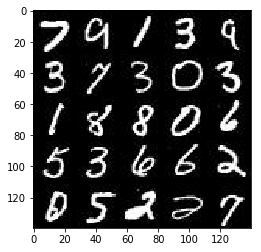

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

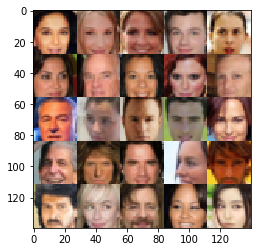

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [45]:
def discriminator(images, reuse=False, alpha =0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input layer is 28 * 28 * 3
        x = tf.layers.conv2d(images, 64, 5, strides = 2,kernel_initializer = tf.random_normal_initializer(stddev=0.02),padding = 'SAME')
        x = tf.maximum(x * alpha, x)
        
        # 14 * 14 *64

        x = tf.layers.conv2d(x, 128, 5, strides= 2,kernel_initializer = tf.random_normal_initializer(stddev=0.02),padding = 'SAME')
        x = tf.maximum(x, alpha*x)
        x = tf.layers.batch_normalization(x, training=True)
        # 7* 7 * 128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2,kernel_initializer = tf.random_normal_initializer(stddev=0.02),  padding='same')
        x = tf.maximum(x, alpha*x)
        x = tf.layers.batch_normalization(x, training=True)
        # 4 * 4 * 256
        
        h1 = tf.reshape(x,(-1, 4*4*256))
        
        
        logits = tf.layers.dense(h1, 1)
        out = tf.sigmoid(logits)
    # TODO: Implement Function

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [46]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x,(-1, 7,7,256))
        
        bnl = tf.layers.batch_normalization(x, training = is_train)
        lrelu1 = tf.maximum(alpha * x, x)
        
        
        # Hidden Layer 2
        x= tf.layers.conv2d_transpose(x, 128, 5, strides=1, padding="SAME")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # Hidden Layer 3
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides = 2, padding = "SAME")
        
        out = tf.tanh(logits)
        
    # TODO: Implement Function
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [47]:
def model_loss(input_real, input_z, out_channel_dim, alpha =0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [48]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [49]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.0272... Generator Loss: 1.3039
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 3.3141
Epoch 1/2... Discriminator Loss: 4.0416... Generator Loss: 0.2149
Epoch 1/2... Discriminator Loss: 4.4109... Generator Loss: 5.3340
Epoch 1/2... Discriminator Loss: 2.7707... Generator Loss: 0.1292
Epoch 1/2... Discriminator Loss: 1.8054... Generator Loss: 1.1667
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 2.1331
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 2.1617


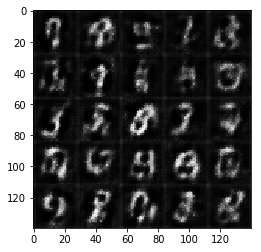

Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.2441
Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 0.7497
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.4896
Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 1.5636
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 0.6810
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.5413... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 0.3441
Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 1.5929


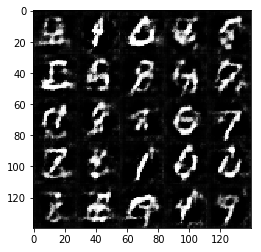

Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.6112... Generator Loss: 0.3237
Epoch 1/2... Discriminator Loss: 0.8443... Generator Loss: 1.9214
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.4863
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 2.1528
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.4813
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 1.7361


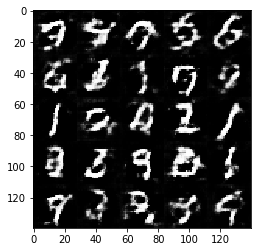

Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 1.5183... Generator Loss: 0.3409
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 1.2367
Epoch 1/2... Discriminator Loss: 0.8726... Generator Loss: 1.7487
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 0.6328
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.4410
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 0.3885
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.4712
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.5220


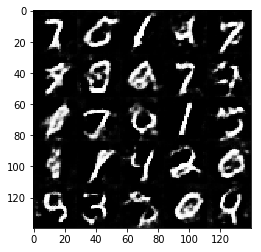

Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 1.1369
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 0.8918
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 1.7856
Epoch 1/2... Discriminator Loss: 1.7673... Generator Loss: 0.2794
Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 1.2445
Epoch 1/2... Discriminator Loss: 0.8396... Generator Loss: 1.1512
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 2.0683
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.2941
Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 1.5732
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 1.4222


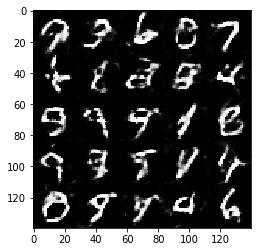

Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.6123
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 0.6111
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.0454
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.5306
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 1.1828
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.4686
Epoch 1/2... Discriminator Loss: 1.7740... Generator Loss: 0.2780
Epoch 1/2... Discriminator Loss: 0.9599... Generator Loss: 0.8051


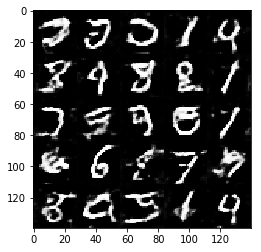

Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.6341
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 1.5316... Generator Loss: 0.3794
Epoch 1/2... Discriminator Loss: 0.7151... Generator Loss: 0.9479
Epoch 1/2... Discriminator Loss: 1.6396... Generator Loss: 0.3146
Epoch 1/2... Discriminator Loss: 0.6027... Generator Loss: 1.5804
Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 0.9337
Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 2.3688
Epoch 1/2... Discriminator Loss: 3.4332... Generator Loss: 4.2893


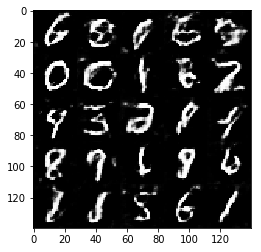

Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 1.9713
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 2.9037
Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 1.8025
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 1.0513
Epoch 1/2... Discriminator Loss: 0.7082... Generator Loss: 1.0413
Epoch 1/2... Discriminator Loss: 3.6627... Generator Loss: 5.5257
Epoch 1/2... Discriminator Loss: 2.4729... Generator Loss: 0.1656
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 3.2112
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.3846


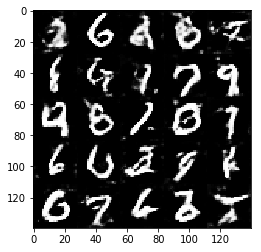

Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 1.8313
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 0.8162
Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 1.5006
Epoch 1/2... Discriminator Loss: 0.6629... Generator Loss: 1.3289
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.6392
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.5840
Epoch 1/2... Discriminator Loss: 1.6642... Generator Loss: 0.3012
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 0.8893
Epoch 1/2... Discriminator Loss: 0.6332... Generator Loss: 1.1078


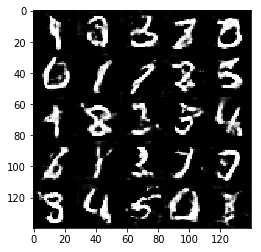

Epoch 1/2... Discriminator Loss: 0.6882... Generator Loss: 0.9400
Epoch 1/2... Discriminator Loss: 0.6310... Generator Loss: 1.0579
Epoch 1/2... Discriminator Loss: 0.5430... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 0.5902... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 1.6274
Epoch 2/2... Discriminator Loss: 1.4437... Generator Loss: 0.4979
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 2.0744
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 0.6346
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 2.3438


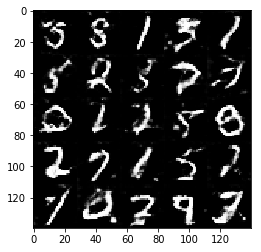

Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 0.9014
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 3.5169
Epoch 2/2... Discriminator Loss: 1.7933... Generator Loss: 0.3959
Epoch 2/2... Discriminator Loss: 1.8696... Generator Loss: 0.3119
Epoch 2/2... Discriminator Loss: 2.3092... Generator Loss: 0.1992
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.0115
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 0.8912
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 0.7737


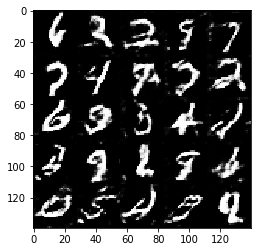

Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 1.2735
Epoch 2/2... Discriminator Loss: 1.6671... Generator Loss: 0.3320
Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 1.2172
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.0310
Epoch 2/2... Discriminator Loss: 8.6639... Generator Loss: 12.1556
Epoch 2/2... Discriminator Loss: 2.3440... Generator Loss: 0.1904
Epoch 2/2... Discriminator Loss: 0.5807... Generator Loss: 1.4914
Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 1.2908


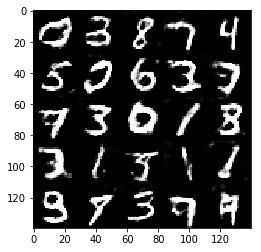

Epoch 2/2... Discriminator Loss: 0.4061... Generator Loss: 1.7403
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 0.5623... Generator Loss: 1.0984
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 0.6510
Epoch 2/2... Discriminator Loss: 0.3227... Generator Loss: 1.5612
Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 0.3342
Epoch 2/2... Discriminator Loss: 0.7171... Generator Loss: 0.8812


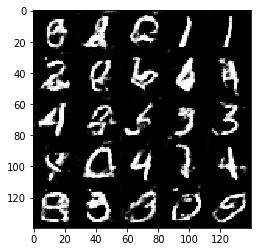

Epoch 2/2... Discriminator Loss: 0.5021... Generator Loss: 1.2903
Epoch 2/2... Discriminator Loss: 0.4537... Generator Loss: 1.2739
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 1.0408
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 0.4155... Generator Loss: 1.3329
Epoch 2/2... Discriminator Loss: 0.3164... Generator Loss: 1.6535
Epoch 2/2... Discriminator Loss: 0.4633... Generator Loss: 1.2469
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 1.0928
Epoch 2/2... Discriminator Loss: 0.2531... Generator Loss: 2.0801
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 0.6665


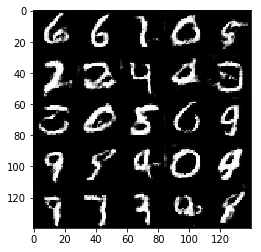

Epoch 2/2... Discriminator Loss: 0.5060... Generator Loss: 1.1753
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 2.5408... Generator Loss: 0.1275
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.4259
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.5461... Generator Loss: 3.1696
Epoch 2/2... Discriminator Loss: 0.5536... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 0.3685... Generator Loss: 2.5793
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 2.3500
Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 0.7290


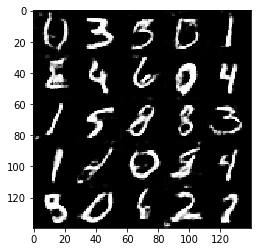

Epoch 2/2... Discriminator Loss: 2.4384... Generator Loss: 0.1650
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 1.4693... Generator Loss: 0.5768
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 0.4045... Generator Loss: 1.4409
Epoch 2/2... Discriminator Loss: 0.4998... Generator Loss: 1.2459
Epoch 2/2... Discriminator Loss: 0.4046... Generator Loss: 1.3750
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 0.8561
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 3.7941


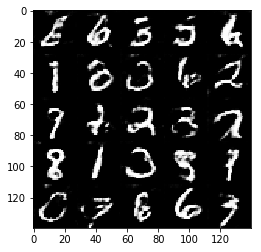

Epoch 2/2... Discriminator Loss: 0.5860... Generator Loss: 1.2931
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 0.8978
Epoch 2/2... Discriminator Loss: 0.3776... Generator Loss: 1.9925
Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 1.0342
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 0.5448... Generator Loss: 1.0271
Epoch 2/2... Discriminator Loss: 0.4522... Generator Loss: 1.2618
Epoch 2/2... Discriminator Loss: 0.3390... Generator Loss: 1.7012
Epoch 2/2... Discriminator Loss: 0.3969... Generator Loss: 1.4006
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 0.8846


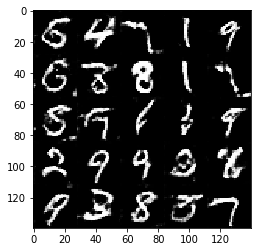

Epoch 2/2... Discriminator Loss: 0.7109... Generator Loss: 0.8502
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 1.1523
Epoch 2/2... Discriminator Loss: 0.2008... Generator Loss: 2.0960
Epoch 2/2... Discriminator Loss: 0.3039... Generator Loss: 1.6448
Epoch 2/2... Discriminator Loss: 0.4209... Generator Loss: 1.3685
Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 1.4808
Epoch 2/2... Discriminator Loss: 0.4370... Generator Loss: 1.3228
Epoch 2/2... Discriminator Loss: 0.6050... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 0.2406... Generator Loss: 1.8051


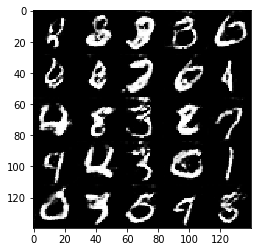

Epoch 2/2... Discriminator Loss: 0.6660... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 0.6525... Generator Loss: 0.9428
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 1.3426
Epoch 2/2... Discriminator Loss: 0.2721... Generator Loss: 1.7782
Epoch 2/2... Discriminator Loss: 0.2802... Generator Loss: 1.7182
Epoch 2/2... Discriminator Loss: 0.1432... Generator Loss: 3.0342
Epoch 2/2... Discriminator Loss: 0.3010... Generator Loss: 1.6459


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 9.9661... Generator Loss: 0.0743
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 3.2783
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.6961
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 3.3349
Epoch 1/1... Discriminator Loss: 2.3872... Generator Loss: 3.6582
Epoch 1/1... Discriminator Loss: 3.3349... Generator Loss: 0.0565
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 1.8794... Generator Loss: 0.7407


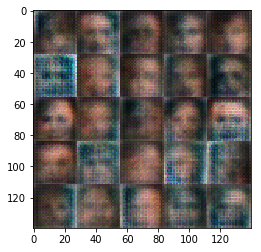

Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 2.3261... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 2.0243... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 2.2495... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.6298


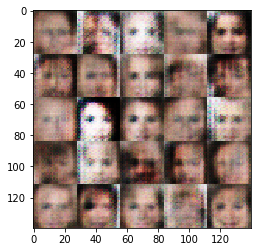

Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.6845... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4015
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7310


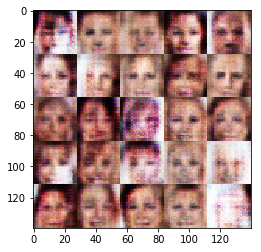

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6243


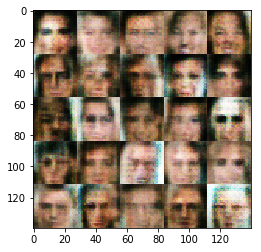

Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.3534
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9221


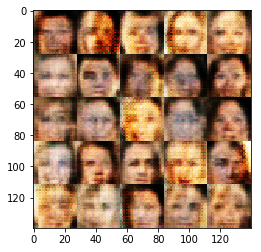

Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.7782... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.8004... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.6583


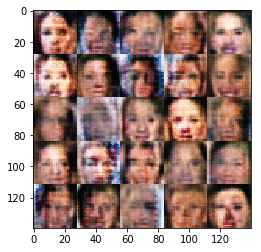

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.7115... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.9255


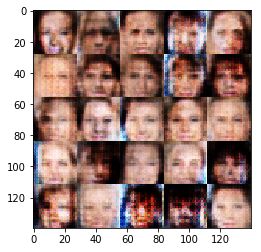

Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.6828


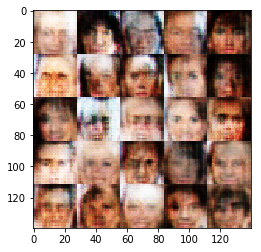

Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 1.1382


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.